# Lecture 14: Neural Networks

## What is a neural network?

The neural network (NN) is a model in AI inspired by the neurons in the brain. It can do classification/categorization, function approximation, and data compression.

Historically, the concept of neural networks is pretty old (the "perceptron" model was proposed in the 50's), but for a long time, NNs didn't perform or scale particularly well, and other simpler models became more popular. It was only around 2006 that our hardware had caught up enough to show the power of neural nets.

The big advantage to them is that they don't have to be explicitly trained, so not even you have to really understand what's going on. The downside of that is that even once you do get it working, you might still not really be able to understand what it's doing (though there are some ways of visualizing its "mysterious" internal thought process).

## Diagram

This doesn't look like a brain to be honest, but we can work with this! Let's go!

![](https://c.mql5.com/18/20/NN1__1.gif)

## How it works

In short, the idea is that we turn our data into an input vector, the NN does a bunch of fancy transformations and spits out another vector, and we interpret this vector to give us our answer.

We start with the $\mathbf{x}$ input layer (equivalently vector). To get to the next layer, $\mathbf{h}^{(1)}$, we apply an affine transformation (linear + some bias offset), denoted by $\Sigma$ in the diagram, followed by a nonlinear transformation, denoted by the step symbol. The nonlinearity is so that combining these layers lets us do more than just a composition of affine transformations. A surprisingly effective transformation is the ReLU (Rectified Linear Unit):
$$\mathrm{ReLU}(x) = \begin{cases}x & \text{if }x > 0 \\ 0 & \text{if }x \leq 0 \end{cases}$$

To get the values at any hidden layer, $\mathbf{h}^{(i)}$, we take the previous layer, $\mathbf{h}^{(i-1)}$, and apply an affine transformation given by the parameters $w_{jk}^{(i-1)}$ and $b_j^{(i-1)}$:
$$h^{(i)}_j = \text{ReLU}\left(b_j^{(i-1)} + \sum_k w_{jk}^{(i-1)} h^{(i-1)}_k\right)$$

For the last layer, we calculate the affine transformation as usual: $\varepsilon_j = b_j^{(\textit{last})} + \sum_k w^{(\textit{last})}_{jk}h^{(\textit{last})}_k$. But instead of applying the ReLU again, we often use a special nonlinear function called softmax which normalizes everything to add up to $1$.
$$y_j = \textrm{softmax}(\varepsilon)_j = \frac{e^{\varepsilon_j}}{\sum_k e^{\varepsilon_k}}$$

## Training a neural net

But wait! How does the neural net know what the weights and biases of these affine transformations should be? We have to train it of course. But first, a word of warning.

### Overfitting and test sets

![](https://imgs.xkcd.com/comics/electoral_precedent.png)

(title text: No white guy who's been mentioned on twitter has gone on to win.)

In all of machine learning, there's a danger that when you train, you'll learn the pecularities of your dataset rather than actually relevant features. This is called *overfitting*, and it's very bad. In order to make sure we're not overfitting, we usually section off a portion of our data not to train on, so we can check how much we're overfitting.

One trick we'll use while training is called *dropout*: we randomly drop certain cells during training, so the net has to learn to be more robust, and it becomes harder to overfit.

### Baby steps

We start with random guesses for all our affine transformation weights, the $w$s and $b$s, and then proceed by correcting the weights in "baby steps", making small corrections to the affine transformations. We use the chain rule to calculate the derivative of error by each of our weights, and we adjust the weights proportionally. (First order taylor series!) We run our network on some examples, add up the errors, fix the weights, and then repeat the process.

Also, in case you have to impress people, the official term for applying the chain rule back is *backpropagation*, because we propagate the error derivatives backwards through the layers, and the deal about training by picking some examples, correcting, and repeating, is called *SGD* (Stochastic Gradient Descent), (there are also fancier descent algorithms which can use variable adjustment sizes and hence converge faster to a solution called *adagrad*, *rmsprop*, etc.).

In [13]:
# If you like this kind of thing, take CS 231N. But let's get started with an example now!
import numpy as np
from matplotlib import pyplot as plt
import keras

%matplotlib inline

In [2]:
# Indeed, keras comes with some preprocessed datasets.
# We'll used the MNIST dataset of handwritten digits.
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 1 # normally you should do more, but for the sake of time...

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# This is where we define the architecture of our NN!
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', # meaning we adjust weights based on the log of the error
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# this example comes from https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [========================

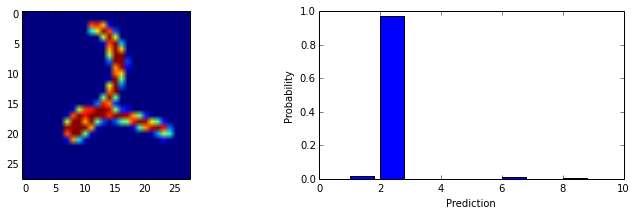

Model predicts 2


In [97]:
# the "show off" cell
def show_off(i):
    fig, ax = plt.subplots(1,2, figsize=(12,3))

    ax[0].imshow(x_test[i].reshape(28,28))

    probs = model.predict(x_test[i:i+1])[0]
    ax[1].bar(np.arange(10), probs)
    ax[1].set_ylabel('Probability')
    ax[1].set_xlabel('Prediction')

    plt.show()

    print('Model predicts', model.predict_classes(x_test[i:i+1], verbose=False)[0])
    
show_off(np.random.randint(10000))

Model's mistakes!


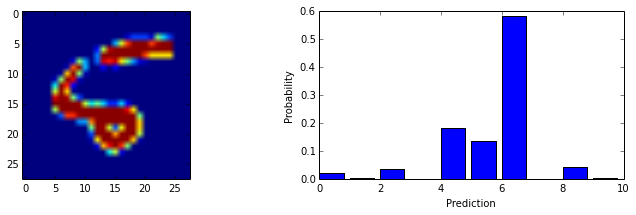

Model predicts 6
Correct answer 5
--------------------------------------------------------------------------------


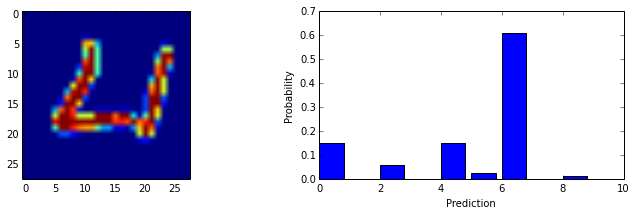

Model predicts 6
Correct answer 4
--------------------------------------------------------------------------------


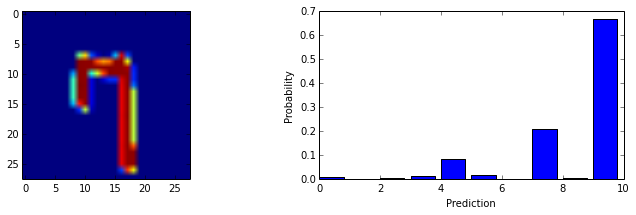

Model predicts 9
Correct answer 7
--------------------------------------------------------------------------------


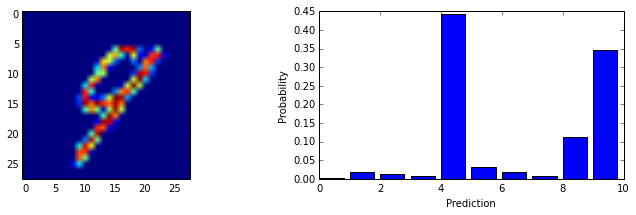

Model predicts 4
Correct answer 9
--------------------------------------------------------------------------------


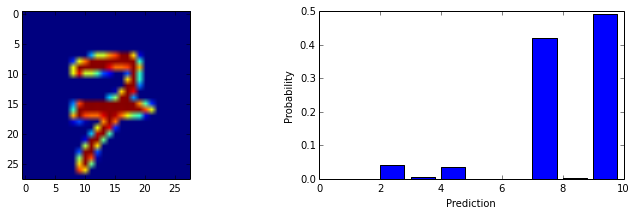

Model predicts 9
Correct answer 7
--------------------------------------------------------------------------------


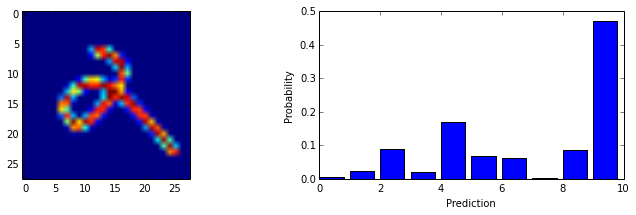

Model predicts 9
Correct answer 2
--------------------------------------------------------------------------------


In [84]:
print("Model's mistakes!")

for i in range(150):
    prediction = model.predict_classes(x_test[i:i+1], verbose=False)[0]
    if y_test[i][prediction] != 1:
        show_off(i)
        print('Correct answer', np.where(y_test[i] == 1)[0][0])
        print('-'*80)
    

## See also
* List of datasets: [https://deeplearning4j.org/opendata](https://deeplearning4j.org/opendata)
* Convolutional neural networks: [https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)